# DATA 620 - Assignment 3 Alt

by: Jeremy OBrien and Mael Illien

Load a graph database of your choosing from a text file or other source. If you take a large network dataset from the web (such as from Stanford Large Network Dataset Collection (https://snap.stanford.edu/data/)), please feel free at this point to load just a small subset of the nodes and edges.

Create basic analysis on the graph, including the graph’s diameter, and at least one other metric of your choosing. You may either code the functions by hand (to build your intuition and insight), or use functions in an existing package.

Use a visualization tool of your choice (Neo4j, Gephi, etc.) to display information. Please record a short video (~ 5 minutes), and submit a link to the video in advance of our meet-up.

Our plan for Assignment 3 is as follows:
1. Load a publicly available, open-source graph dataset
2. Downsample the graph for ease of visualization
3. Visualize the graph using Neo4j
4. Calculate diagnostics using NetworkX

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

For Assignment 3 we sourced a Bitcoin OTC trusted weighted signed network dataset from the [Stanford Network Analysis Project](https://snap.stanford.edu/data/soc-sign-bitcoin-otc.html).

[Bitcoin OTC](https://www.bitcoin-otc.com/) is an over-the-counter marketplace for trading bitcoin which also offers a web-of-trust service.  The dataset captures a who-trusts-whom network of anonymous individuals using the Bitcoing OTC platform.  From the perspective of network topology, individuals comprise nodes, relationships are directed edges, and edge weights are trust ratings provided by one user (source node) of another user (target node) on a scale of -10 (total distrust) through 0 (neutral) to +10 (total trust).

This dataset is credited to:
- S. Kumar, F. Spezzano, V.S. Subrahmanian, C. Faloutsos. [Edge Weight Prediction in Weighted Signed Networks](https://cs.stanford.edu/~srijan/pubs/wsn-icdm16.pdf). IEEE International Conference on Data Mining (ICDM), 2016.
- S. Kumar, B. Hooi, D. Makhija, M. Kumar, V.S. Subrahmanian, C. Faloutsos. [REV2: Fraudulent User Prediction in Rating Platforms](https://cs.stanford.edu/~srijan/pubs/rev2-wsdm18.pdf). 11th ACM International Conference on Web Searchand Data Mining (WSDM), 2018.

In [ ]:
# Import data using pandas
url = 'https://raw.githubusercontent.com/JeremyOBrien16/CUNY_DATA_620/master/Assignment03/soc-sign-bitcoinotc.csv'
ratings = pd.read_csv(url, names=['SOURCE','TARGET','RATING','TIMESTAMP'] )
ratings

,SOURCE,TARGET,RATING,TIMESTAMP
0,6,2,4,1.289242e+09
1,6,5,2,1.289242e+09
2,1,15,1,1.289243e+09
3,4,3,7,1.289245e+09
4,13,16,8,1.289254e+09
...,...,...,...,...
35587,4499,1810,1,1.453612e+09
35588,2731,3901,5,1.453679e+09
35589,2731,4897,5,1.453679e+09
35590,13,1128,1,1.453680e+09


#### Load data into a graph using NetworkX

In [20]:
# Compose a directed graph of Bitcoin OTC users
data = open('soc-sign-bitcoinotc.csv', 'r')
graphtype = nx.DiGraph()
graph = nx.parse_edgelist(data, 
                      delimiter=',', 
                      create_using=graphtype,
                      nodetype=int, 
                      data=(('weight', float),('time', float)))

In [21]:
# Calculate number of users
len(graph.nodes)

5881

In [22]:
# Calculate number of ratings
len(graph.edges)

35592

In [6]:
# Expand on this graph as needed

#### Downsample the full graph

Given the large size of the Bitcoin OTC network, we'll downsample the number of nodes to reduce the computational resources needed for this Assignment 3.  We use the following procedure:
1. Quasi-randomly sample n = ??? users from the full network, which will serve as source nodes
2. Map other users rated by this random user sample, tracing the outbound directed edges from these source nodes (target nodes)

In [3]:
# Randomly sample 50 users
unique_users = set(ratings['SOURCE']) # Identify unique users
downsample_n = 50 # Set source node sample 
random.seed(620)
ratings_subset = ratings[ratings['SOURCE'].isin(random.sample(unique_users, downsample_n))]

source_nodes = list(set(ratings_subset['SOURCE']))
target_nodes = list(set(ratings_subset['TARGET']))
all_nodes = source_nodes + target_nodes

# Calculate total nodes in random sample
print(len(source_nodes),len(target_nodes),len(all_nodes))

The downsampling procedure yields a smaller, shallower directed graph of 39 total nodes.  This graph will be more amenable to easy visualization than the full graph.

In [9]:
# Do we need to include this cell in the submission?
# ratings_subset

,SOURCE,TARGET,RATING,TIMESTAMP
90,41,36,2,1.292206e+09
127,41,75,1,1.293584e+09
139,41,60,1,1.293820e+09
148,41,4,1,1.294081e+09
159,41,83,1,1.294263e+09
...,...,...,...,...
35291,5972,13,1,1.437803e+09
35304,41,5974,2,1.438383e+09
35432,3719,1272,-10,1.442418e+09
35433,41,4291,2,1.442787e+09


In [6]:
# Reset the index of sample graph
ratings_subset = ratings_subset.reset_index()

In [7]:
# Do we need to include this cell in the submission?
# ratings_subset

,index,SOURCE,TARGET,RATING,TIMESTAMP
0,90,41,36,2,1.292206e+09
1,127,41,75,1,1.293584e+09
2,139,41,60,1,1.293820e+09
3,148,41,4,1,1.294081e+09
4,159,41,83,1,1.294263e+09
...,...,...,...,...,...
581,35291,5972,13,1,1.437803e+09
582,35304,41,5974,2,1.438383e+09
583,35432,3719,1272,-10,1.442418e+09
584,35433,41,4291,2,1.442787e+09


In [ ]:
# Do we need to include the ensuing cells?

### Sample Cypher Queries:

In [13]:
# Return all the nodes
"MATCH (n) RETURN n"

# Delete everything
"MATCH (n) DETACH DELETE n"

'MATCH (n) DETACH DELETE n'

### Load sample graph into Neo4j

In order to visualize the sample graph, we first load the data into Neo4j using Pandas to output separate nodes and edges CSV files.

In [12]:
# Output nodes from sample graph to CSV
df = pd.DataFrame(all_nodes)
df.columns = ['usr_id']
#df
df.to_csv('nodes.csv')

In [9]:
# Output directed edges and weights (ratings) from sample graph to CSV
df = ratings[ratings['SOURCE'].isin(list(source_nodes))]
df = df[['SOURCE','TARGET','RATING']]
#df
df.to_csv('edges.csv')

In [16]:
# Create nodes in Neo4j
"""LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/JeremyOBrien16/CUNY_DATA_620/master/Assignment03/nodes.csv" AS csvLine
CREATE (u:User {usr_id: (csvLine.usr_id)})"""

'LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/JeremyOBrien16/CUNY_DATA_620/master/Assignment03/nodes.csv" AS csvLine\nCREATE (u:User {id: (csvLine.id)})'

In [17]:
# Create edges in Neo4j
"""LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/JeremyOBrien16/CUNY_DATA_620/master/Assignment03/edges.csv" AS csvLine
MATCH (u1:User {usr_id: csvLine.SOURCE})
MATCH (u2:User {usr_id: csvLine.TARGET})
CREATE (u1)-[:TRUSTS {rating: csvLine.RATING}]->(u2)"""

'LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/JeremyOBrien16/CUNY_DATA_620/master/Assignment03/edges.csv" AS csvLine\nMATCH (u1:User {id: csvLine.SOURCE})\nMATCH (u2:User {id: csvLine.TARGET})\nCREATE (u1)-[:TRUSTS {rating: csvLine.RATING}]->(u2)'

### Visualize sample graph using Neo4j

In [ ]:
# Should we include code to produce the graph below? 

A Neo4j visualization of the sample graph is below.  It's not possible to say if network characteristics are shared by the full graph or purely a result of our sampling procedure.  From a visual analysis, we do note the following:
- Two relatively dense neighborhoods in the upper right and lower right corners, connected directly (nodes 545 and 4197) and via several intermediaries (nodes 7, 57, 1018, and 2028) 
- To isolated branches on the periphery connected to the network by node 2028
- A single island remote and unconnected to the rest of the network, comprised of nodes 524 and 359

![Neo4j Graph](https://raw.githubusercontent.com/JeremyOBrien16/CUNY_DATA_620/master/Assignment03/graph.png)

From this graph, we can identify a central network in the center to investigate further. Here is the resulting subgraph for the network

![Neo4j Graph](https://raw.githubusercontent.com/JeremyOBrien16/CUNY_DATA_620/master/Assignment03/subgraph.png)

### Export graph from Neo4j into NetworkX to calculate diagnostic metrics

@Mael, would you mind adding some write-up to this section?  I'm going offline briefly.

In [13]:
from neo4j import GraphDatabase
from neo4jconfig import neo4j_auth
%matplotlib inline

In [98]:
gdb = GraphDatabase.driver(uri=neo4j_auth['uri'],auth=(neo4j_auth['user'],neo4j_auth['password']), encrypted=False)
session = gdb.session()

In [94]:
# Obtain subgraph from Neo4j
query = """
MATCH (u:User {usr_id: "2296"})
CALL apoc.path.subgraphAll(u, {
    relationshipFilter: "TRUSTS",
    minLevel: 0,
    maxLevel: 10
})
YIELD nodes, relationships
RETURN nodes AS n, relationships AS r
"""
records = session.run(query)
#l = [r['nodes'] for r in records]
#l = [r['nodes'] for r in records]
#print(l[0])
for r in records:
    node = r['r']
    print(node)

[<Relationship id=986 nodes=(<Node id=2304 labels={'User'} properties={'usr_id': '2296'}>, <Node id=2633 labels={'User'} properties={'usr_id': '3410'}>) type='TRUSTS' properties={'rating': '-1'}>, <Relationship id=1007 nodes=(<Node id=2304 labels={'User'} properties={'usr_id': '2296'}>, <Node id=2697 labels={'User'} properties={'usr_id': '3643'}>) type='TRUSTS' properties={'rating': '1'}>, <Relationship id=1009 nodes=(<Node id=2304 labels={'User'} properties={'usr_id': '2296'}>, <Node id=2706 labels={'User'} properties={'usr_id': '3661'}>) type='TRUSTS' properties={'rating': '1'}>, <Relationship id=858 nodes=(<Node id=2304 labels={'User'} properties={'usr_id': '2296'}>, <Node id=2438 labels={'User'} properties={'usr_id': '353'}>) type='TRUSTS' properties={'rating': '2'}>, <Relationship id=1034 nodes=(<Node id=2304 labels={'User'} properties={'usr_id': '2296'}>, <Node id=2747 labels={'User'} properties={'usr_id': '3825'}>) type='TRUSTS' properties={'rating': '1'}>, <Relationship id=916 

In [66]:
# Return all nodes
records = session.run("MATCH (n) RETURN n")
for r in records:
    print(r['n'])

<Node id=2256 labels={'User'} properties={'usr_id': '1026'}>
<Node id=2257 labels={'User'} properties={'usr_id': '2053'}>
<Node id=2258 labels={'User'} properties={'usr_id': '4485'}>
<Node id=2259 labels={'User'} properties={'usr_id': '3335'}>
<Node id=2260 labels={'User'} properties={'usr_id': '3719'}>
<Node id=2261 labels={'User'} properties={'usr_id': '524'}>
<Node id=2262 labels={'User'} properties={'usr_id': '2189'}>
<Node id=2263 labels={'User'} properties={'usr_id': '4620'}>
<Node id=2264 labels={'User'} properties={'usr_id': '657'}>
<Node id=2265 labels={'User'} properties={'usr_id': '4886'}>
<Node id=2266 labels={'User'} properties={'usr_id': '3607'}>
<Node id=2267 labels={'User'} properties={'usr_id': '792'}>
<Node id=2268 labels={'User'} properties={'usr_id': '409'}>
<Node id=2269 labels={'User'} properties={'usr_id': '282'}>
<Node id=2270 labels={'User'} properties={'usr_id': '4375'}>
<Node id=2271 labels={'User'} properties={'usr_id': '414'}>
<Node id=2272 labels={'User'} 

In [68]:
# Return all relationships
records = session.run("MATCH (n) OPTIONAL MATCH (n)-[r]->() RETURN n, r")
for r in records:
    rel = r['r']
    if rel is not None:
        #print(rel)
        print(rel.start_node['usr_id'], rel.end_node['urs_id'], rel['rating'])

1026 None 1
1026 None 1
1026 None 2
1026 None 1
1026 None 2
1026 None -1
1026 None 10
1026 None 5
1026 None 2
2053 None 2
2053 None -10
2053 None 2
2053 None -10
2053 None 1
2053 None 2
2053 None -5
2053 None 3
2053 None -10
2053 None -10
2053 None -5
2053 None 1
4485 None 1
3335 None 1
3335 None 4
3335 None 2
3335 None 1
3335 None 1
3335 None 2
3335 None 3
3335 None 2
3335 None 5
3335 None 1
3335 None 2
3719 None 2
3719 None 1
3719 None 2
3719 None 2
3719 None -10
3719 None 3
3719 None -10
3719 None 1
3719 None 1
3719 None 2
3719 None 4
3719 None -10
3719 None -10
3719 None -5
3719 None 1
3719 None 1
3719 None 1
3719 None 1
3719 None 2
3719 None -10
3719 None 3
3719 None 2
3719 None 2
3719 None 3
3719 None 1
3719 None -3
3719 None 1
3719 None 1
3719 None 1
3719 None 1
3719 None 4
3719 None 1
3719 None 2
3719 None -5
3719 None 1
3719 None 1
3719 None 6
3719 None 1
3719 None 1
3719 None -10
3719 None 1
3719 None 1
3719 None 1
3719 None 1
3719 None 1
3719 None 3
3719 None -10
3719 None -

In [ ]:
result = session.run("MATCH (u1:User {id: '2296'})-[r:TRUSTS]->(u2) RETURN u1, u2, r.rating AS rating")
for r in result:
    print(r)
    #print(r['u1'], r['u2'].id, r['rating'])
    #print(r['u1'].id, r['u2'].id, r['rating'])
    
#ratings = [(record["rating"] for record in result]
#ratings

In [99]:
# Return all nodes
result = session.run("MATCH (u:User) RETURN u.id AS id")
labels = [] # Used in graphing
node_ids = [record["id"] for record in result]
node_ids = np.array(node_ids).astype(np.int)

TypeError: int() argument must be a string, a bytes-like object or a number, not 'NoneType'

In [100]:
def rec2graph(rs):
    graph = nx.MultiDiGraph()
    
    for n_id in node_ids:
        #print(type(n_id))
        nx_properties = {}
        graph.add_node(n_id, **nx_properties)
        labels.append(n_id)
    
    for record in rs:
        rel = record['r']
        #print(rel)
        if rel is not None:
                graph.add_edge(rel.start_node['id'], rel.end_node['id'], weight=rel['rating'])
            
    return graph

In [101]:
records = session.run("MATCH (n) OPTIONAL MATCH (n)-[r]->() RETURN n, r")
g = rec2graph(records)
print(nx.info(g))

Name: 
Type: MultiDiGraph
Number of nodes: 1
Number of edges: 594
Average in degree: 594.0000
Average out degree: 594.0000


In [102]:
plt.rcParams['figure.figsize'] = [20, 10]

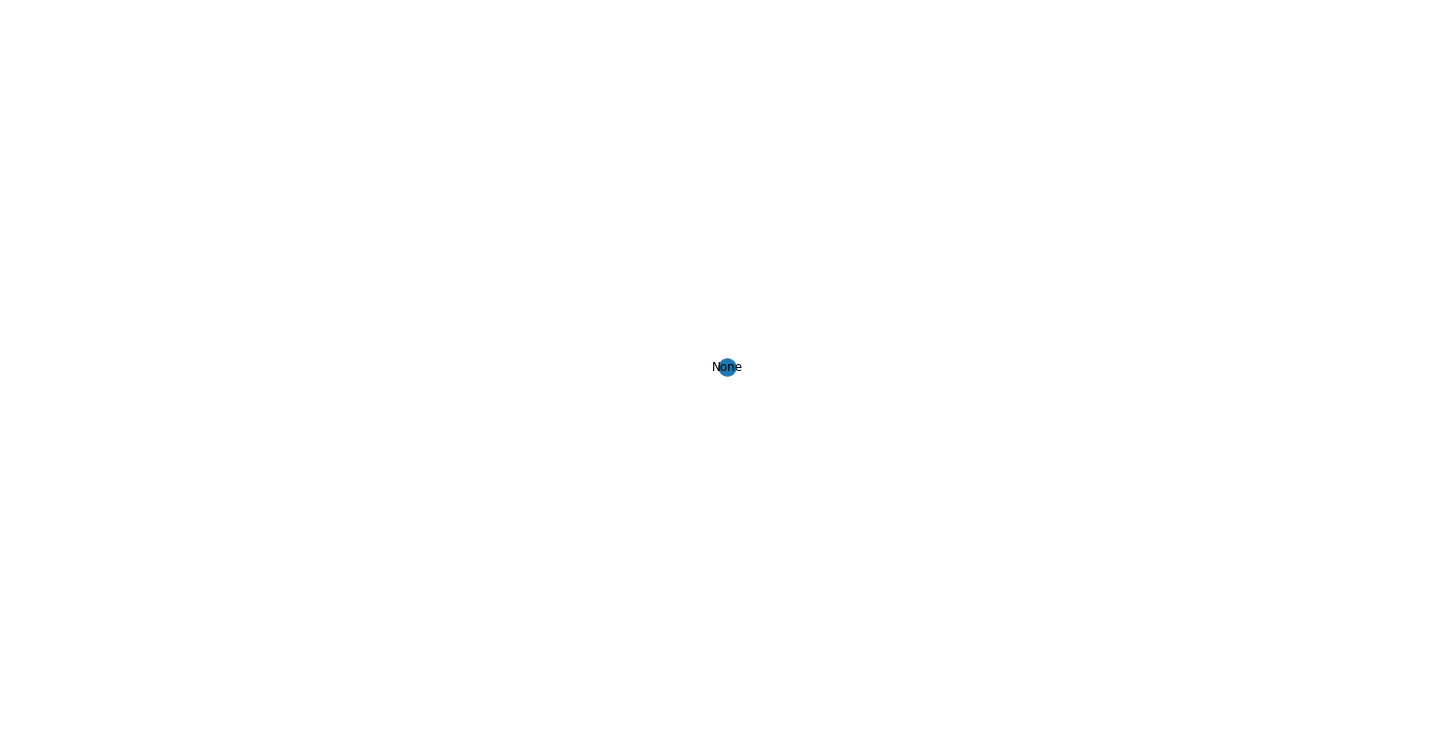

In [103]:
# Simple graph
nx.draw(g, with_labels=True)

In [ ]:
graph_pos = nx.spring_layout(g)
labels = dict(zip(node_ids,labels))

In [ ]:
fig = nx.draw_networkx_nodes(g, graph_pos, alpha=.5, node_color='blue')
fig = nx.draw_networkx_edges(g, graph_pos, width=1, alpha=.3, edge_color='blue')
fig = nx.draw_networkx_labels(g, graph_pos, labels=labels, font_size=10, font_family='Arial')

In [ ]:
df = pd.DataFrame(index=ids)
pagerank = nx.pagerank(g, alpha=.9)
df['pagerank'] = [pagerank[n] for n in ids]

betweenness = nx.betweenness_centrality(g)
df['betweenness'] = [betweenness[n] for n in ids]

In [ ]:
nx.diameter(g)